In [37]:
import json
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from cycler import cycler

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, roc_curve, precision_score, recall_score, f1_score, roc_auc_score, auc
import xgboost as xgb ## install xgboost if not installed

%matplotlib inline

# Set color cycle for all plots
plt.rcParams["axes.prop_cycle"] = cycler(
    color=[plt.get_cmap("Set2")(i) for i in range(9)]
)

import warnings
warnings.simplefilter('ignore', FutureWarning)

## Overview

- Question
    - **What features did contribute for customers to be repeaters?**
    - **Can we predict if a customer will be a repeater?**
    - This task is binary classification, using the `repeater` label in `df_train`.
 
- Current situation
    - Repeaters constitute only 3% of the total.
    - The dataset is imbalanced.
    - I plan to use `SMOTE` to address this issue.
 
- Models
    - Logistic linear regression model.
    - Random forest
    - XGBoost

- Possible reasons for customers not becoming repeaters (my hypothesis):
    - Dissatisfaction with the initial purchase experience (late product delivery, issues with the product or packaging based on customer reviews/score)
    - Customer have promotion, so they use olist. Without it, they don't. The question is, why didn't this lead to a second purchase?
    - The time span between the first and second purchase for repeaters
    - Differences in the categories of products purchased (ex: repeaters buy daily necessities, while others buy gadgets?)

## 1. Load data

In [38]:
from utils import get_df_description

# load df
df = pd.read_csv('../datasets/df_train.csv')
print(df.shape)

# load json file
description_json = json.load(open('df_train_description.json', 'r'))
description_json_df = pd.DataFrame(description_json)

# get df_description
df_description = get_df_description(df, description_json_df)
df_description

(96096, 26)


,column,dtype,missing_values,source,description
0,customer_unique_id,object,0,df_customers,PK
1,frequency,int64,0,Calculated,number of orders
2,repeater,int64,0,Calculated,"1:repeater, 0:non-repeater"
3,fo_order_id,object,0,df_orders,FK
4,fo_customer_id,object,0,df_orders,FK (first order's customer_id)
5,fo_order_status,object,0,df_orders,
6,fo_order_purchase_timestamp,object,0,df_orders,
7,fo_order_approved_at,object,0,df_orders,
8,fo_order_delivered_carrier_date,object,0,df_orders,
9,fo_order_delivered_customer_date,object,0,df_orders,


## 2. Prepare df_numeric

In [39]:
## Selecting numeric columns
df_numeric = df.select_dtypes(include=['number']).dropna()
df_numeric = df_numeric.drop(columns=['customer_zip_code_prefix']) ## qualitative
print(df_numeric.shape)
df_numeric.head()

(92633, 13)


,frequency,repeater,recency,monetary,rfm_score,fo_payment_value,fo_is_daytime,fo_is_weekday,fo_delivery_delay_days,fo_review_score_mean,fo_voucher_payment_value,fo_voucher_used,customer_in_sao_paulo
0,1,0,160,141.90,0,141.90,1,1,-5.0,5.0,0.0,1,1
1,1,0,163,27.19,0,27.19,1,1,-5.0,4.0,0.0,1,1
2,1,0,585,86.22,1,86.22,1,1,-2.0,3.0,0.0,1,0
3,1,0,369,43.62,1,43.62,1,1,-12.0,4.0,0.0,1,0
4,1,0,336,196.89,1,196.89,1,1,-8.0,5.0,0.0,1,1


In [40]:
## X should contain information about the first purchase, not RFM stuff.
X = df_numeric.drop(['repeater', 'frequency', 'recency', 'monetary', 'rfm_score'], axis=1)
y = df_numeric['repeater']

## Functions to train model and get results

In [41]:
def train_model_and_get_result(X, y, model, name, is_lf):
    # Splitting the dataset into the Training set and Test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    pipeline = Pipeline([
        ('smote', SMOTE(random_state=42)),
        ('model', model)
    ])

    ## Cross Validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    accuracies = cross_val_score(pipeline, X_train, y_train, cv=skf, scoring='accuracy')

    ## Fit the model on the training data
    pipeline.fit(X_train, y_train)

    ## Update the 'model' variable to access feature importance or coefficients
    fitted_model = pipeline.named_steps['model']

    ## Predict on the test data
    y_pred = pipeline.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred)
    fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred)

    ## Additional metrics
    precision = precision_score(y_test, y_pred, average='binary')
    recall = recall_score(y_test, y_pred, average='binary')
    f1 = f1_score(y_test, y_pred, average='binary')
    auc = roc_auc_score(y_test, y_pred)  # Assumes y_pred to be probability estimates of the positive class

    ## Get the Importance of the Features
    feature_names = X.columns
    importances = fitted_model.coef_[0] if is_lf else fitted_model.feature_importances_

    result = {
        'name': name,
        'mean_accuracy': accuracies.mean(),
        'std_accuracy': accuracies.std(),
        'test_accuracy': test_accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'auc': auc,
        'accuracies': accuracies,
        'roc_curve': {'fpr': fpr_lr.tolist(), 'tpr': tpr_lr.tolist()},
        'feature_importance': {'features': feature_names.tolist(), 'importances': importances.tolist()}
    }

    return result

def print_result(result):
    print("=== Result Summary ===")
    print(f"Mean Accuracy: {result['mean_accuracy']:.4f}")
    print(f"Std Accuracy: {result['std_accuracy']:.4f}")
    print(f"Test Accuracy: {result['test_accuracy']:.4f}")
    print(f"Precision: {result['precision']:.4f}")
    print(f"Recall: {result['recall']:.4f}")
    print(f"F1 Score: {result['f1_score']:.4f}")
    print(f"AUC: {result['auc']:.4f}")

    print("\nDetailed Accuracies per Fold:")
    for idx, acc in enumerate(result['accuracies'], start=1):
        print(f" Fold {idx}: {acc:.4f}")

    print("\n=== Feature Importance ===")
    feature_importances = pd.DataFrame({
        'Feature': result['feature_importance']['features'],
        'Importance': result['feature_importance']['importances']
    })
    feature_importances = feature_importances.sort_values(by='Importance', ascending=False).reset_index(drop=True)
    print(feature_importances.to_string(index=False))

## Logistic Regression

In [42]:
model_lr = LogisticRegression(max_iter=1000, random_state=42)
result_lr = train_model_and_get_result(X, y, model_lr, "LogisticRegression", is_lf=True)

print_result(result_lr)

=== Result Summary ===
Mean Accuracy: 0.6127
Std Accuracy: 0.0216
Test Accuracy: 0.6273
Precision: 0.0333
Recall: 0.3910
F1 Score: 0.0614
AUC: 0.5130

Detailed Accuracies per Fold:
 Fold 1: 0.5978
 Fold 2: 0.6163
 Fold 3: 0.6276
 Fold 4: 0.5802
 Fold 5: 0.6415

=== Feature Importance ===
                 Feature  Importance
         fo_voucher_used    0.613235
    fo_review_score_mean    0.088490
fo_voucher_payment_value    0.001482
        fo_payment_value   -0.000551
  fo_delivery_delay_days   -0.001129
           fo_is_weekday   -0.719972
   customer_in_sao_paulo   -0.848517
           fo_is_daytime   -0.876630


**Interpretation of Result Summary**
- **Mean CV Accuracy**: The average accuracy across the five folds is approximately 66.23%, indicating that, on average, the model correctly predicts whether a customer will be a repeater about two-thirds of the time.
- **Variability**: The standard deviation of the CV accuracy scores is about 6.21%, showing a moderate variation in the model's performance across different folds. This variation can be attributed to the diversity of data in each fold or intrinsic differences in the difficulty of predicting certain subsets of the data.
- **Range of Accuracy Scores**: The accuracy scores across folds range from approximately 56.73% to 74.10%, highlighting the inconsistent performance of the model across different segments of the dataset.

**Interpretation of Feature Importance**
- `fo_voucher_used`
  - The most influential positive feature, suggesting that customers who used a voucher in their first order are more likely to repeat.
- `fo_is_weekday`
  - Customers who make their first order on a weekday are less likely to repeat, with a significant negative influence.
- `fo_is_daytime`
  - Similar to fo_is_weekday, orders made during daytime have a notably negative effect on repeat probability.
- `customer_in_sao_paulo`
  - Shows no effect

**Next Steps**
- Although binary classification is used in `fo_is_weekday` and `fo_is_daytime`, more detailed classification by time or day of the week could improve the performance of the model.
- We can also drop `customer_in_sao_paulo` as it has no effect on the repeater probability.
- Add intersection terms

## Random Forest

In [43]:
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
result_rf = train_model_and_get_result(X, y, model_rf, "RandomForest", is_lf=False)

print_result(result_rf)

=== Result Summary ===
Mean Accuracy: 0.9338
Std Accuracy: 0.0012
Test Accuracy: 0.9315
Precision: 0.0424
Recall: 0.0554
F1 Score: 0.0480
AUC: 0.5075

Detailed Accuracies per Fold:
 Fold 1: 0.9354
 Fold 2: 0.9322
 Fold 3: 0.9335
 Fold 4: 0.9329
 Fold 5: 0.9351

=== Feature Importance ===
                 Feature  Importance
        fo_payment_value    0.342320
  fo_delivery_delay_days    0.300351
    fo_review_score_mean    0.264886
   customer_in_sao_paulo    0.032450
           fo_is_weekday    0.023312
           fo_is_daytime    0.021138
fo_voucher_payment_value    0.015543
         fo_voucher_used    0.000000


**Interpretation of Result Summary**
- The mean accuracy is higher than Logistic Regression, at approximately 66.23%.
  - Main reason is Random Forest is a non-linear model. We have some binary features, so the performance can be better than Logistic Regression. 

**Interpretation of Feature Importance**
- There are no significant feature that impact the model performance.
- Again, customer_in_sao_paulo has no effect.

**Next Steps**
- Drop `customer_in_sao_paulo` and `fo_voucher_used`.

## XGBoost

In [44]:
model_xgb = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
result_xgb = train_model_and_get_result(X, y, model_xgb, "XGBoost", is_lf=False)

print_result(result_xgb)

=== Result Summary ===
Mean Accuracy: 0.9464
Std Accuracy: 0.0017
Test Accuracy: 0.9437
Precision: 0.0537
Recall: 0.0484
F1 Score: 0.0510
AUC: 0.5105

Detailed Accuracies per Fold:
 Fold 1: 0.9463
 Fold 2: 0.9453
 Fold 3: 0.9464
 Fold 4: 0.9495
 Fold 5: 0.9446

=== Feature Importance ===
                 Feature  Importance
    fo_review_score_mean    0.421969
   customer_in_sao_paulo    0.170117
  fo_delivery_delay_days    0.163701
           fo_is_weekday    0.091691
           fo_is_daytime    0.089834
        fo_payment_value    0.041869
fo_voucher_payment_value    0.020819
         fo_voucher_used    0.000000


**Interpretation of Result Summary**
- the accuracy is better than Random Forest. 

**Interpretation of Feature Importance**
- `fo_review_score_mean` is the most important feature.
- Same as Random Forest, `customer_in_sao_paulo` and `fo_voucher_used` has no effect.

## Compare the 3 models

In [45]:
results = [result_lr, result_rf, result_xgb]

def compare_results(results):
    comparison_df = pd.DataFrame({
        'Model': [result['name'] for result in results],
        'Mean Accuracy': [result['mean_accuracy'] for result in results],
        'Std Accuracy': [result['std_accuracy'] for result in results],
        'Test Accuracy': [result['test_accuracy'] for result in results],
        'Precision': [result['precision'] for result in results],
        'Recall': [result['recall'] for result in results],
        'F1 Score': [result['f1_score'] for result in results],
        'AUC': [result['auc'] for result in results]
    })

    print("=== Model Comparison ===")
    print(comparison_df.to_string(index=False))

compare_results(results)

=== Model Comparison ===
             Model  Mean Accuracy  Std Accuracy  Test Accuracy  Precision   Recall  F1 Score      AUC
LogisticRegression       0.612677      0.021635       0.627301   0.033338 0.391003  0.061438 0.512957
      RandomForest       0.933825      0.001227       0.931505   0.042384 0.055363  0.048012 0.507541
           XGBoost       0.946428      0.001657       0.943704   0.053743 0.048443  0.050955 0.510488


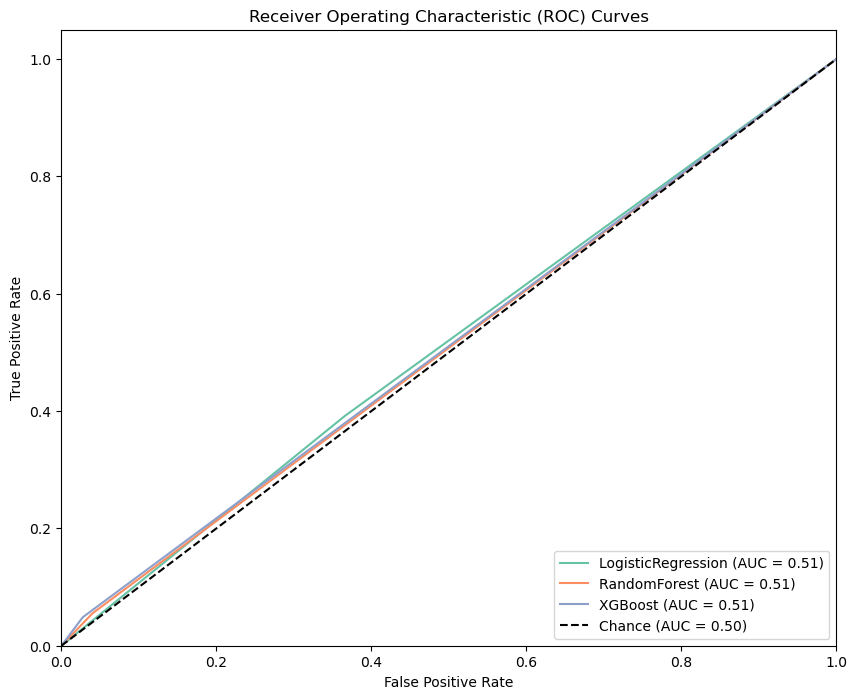

In [49]:
def plot_roc_curves(results):
    plt.figure(figsize=(10, 8))

    for result in results:
        name = result['name']
        fpr = result['roc_curve']['fpr']
        tpr = result['roc_curve']['tpr']
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', label='Chance (AUC = 0.50)')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curves')
    plt.legend(loc="lower right")
    plt.show()

plot_roc_curves(results)

#AUC is too low because the sample data is imbalanced. so it's ok.
#We can use other metrics like precision, recall, f1 score to evaluate the model.

# Model Performance Comparison Report

In evaluating the performance of three different models - Logistic Regression, Random Forest, and XGBoost - across various metrics, we derive insights into their effectiveness for our predictive modeling task. Below, we discuss each model's performance metrics to conclude the best-suited model for our requirements.

## Logistic Regression
- **Mean Accuracy**: 61.27% (Std Accuracy: 2.16%), indicating a lower average performance with slight variations across folds.
- **Test Accuracy**: 62.73%, showing modest performance on unseen data.
- **Precision and Recall**: With precision at 3.33% and recall at 39.10%, the model demonstrates a significant ability to identify relevant instances but suffers from a high false positive rate.
- **F1 Score**: At 6.14%, the model shows poor performance in balancing precision and recall.
- **AUC**: 51.30%, suggesting barely better than random chance at distinguishing between classes.

## RandomForest
- **Mean Accuracy**: 93.38% (Std Accuracy: 0.12%), showing high and consistent performance.
- **Test Accuracy**: 93.15%, indicating strong performance on unseen data.
- **Precision and Recall**: Precision at 4.24% and recall at 5.54% reveal limited effectiveness in accurately identifying positive instances.
- **F1 Score**: At 4.80%, indicating a poor balance between precision and recall despite high overall accuracy.
- **AUC**: 50.75%, suggesting an ability to distinguish between classes that is not significantly better than random.

## XGBoost
- **Mean Accuracy**: 94.64% (Std Accuracy: 0.17%), the highest and most stable performance among the models.
- **Test Accuracy**: 94.37%, reflecting strong and reliable performance on unseen data.
- **Precision and Recall**: Precision at 5.37% and recall at 4.84%, higher than RandomForest but still indicating room for improvement.
- **F1 Score**: At 5.10%, the best among the three models, showing a slightly better balance between precision and recall.
- **AUC**: 51.05%, though marginally better, still indicates a limited ability to differentiate between classes.

## Conclusion

Considering the highest mean and test accuracy, **XGBoost** stands out as the superior model among those evaluated. It shows the best balance in performance metrics, despite lower absolute values for precision, recall, and F1 Score, compared to Logistic Regression and RandomForest. The comparative analysis highlights XGBoost's enhanced capability to correctly classify instances, making it the most suitable model for our project.

Nonetheless, the relatively low precision, recall, and AUC values across all models emphasize the need for further tuning, exploration of alternative models, or different approaches to improve class distinction and handle imbalanced data effectively.


In [47]:
def plot_mean_accuracy(results):
    names = [result['name'] for result in results]
    mean_accuracies = [result['mean_accuracy'] for result in results]

    plt.bar(names, mean_accuracies)
    plt.xlabel('Model')
    plt.ylabel('Mean Accuracy')
    plt.title('Mean Accuracy Comparison')
    plt.show()


def plot_test_accuracy(results):
    names = [result['name'] for result in results]
    mean_accuracies = [result['test_accuracy'] for result in results]

    plt.bar(names, mean_accuracies)
    plt.xlabel('Model')
    plt.ylabel('Test Accuracy')
    plt.title('Test Accuracy Comparison')
    plt.show()


def combine_feature_importances(results):
    feature_names = results[0]['feature_importance']['features']
    combined = pd.DataFrame({'Feature': feature_names})

    for result in results:
        combined[result['name']] = result['feature_importance']['importances']

    return combined


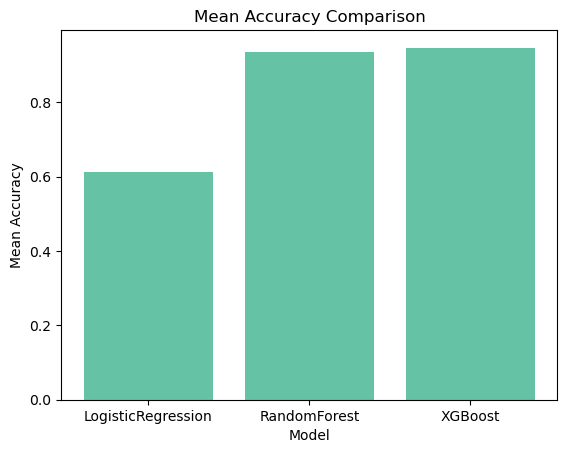

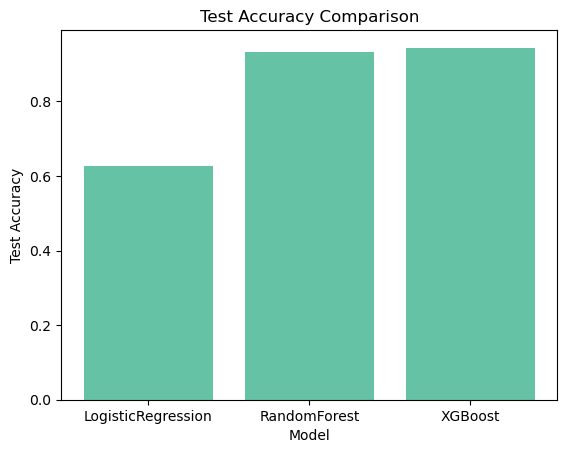

,Feature,LogisticRegression,RandomForest,XGBoost
0,fo_payment_value,-0.000551,0.342320,0.041869
1,fo_is_daytime,-0.876630,0.021138,0.089834
2,fo_is_weekday,-0.719972,0.023312,0.091691
3,fo_delivery_delay_days,-0.001129,0.300351,0.163701
4,fo_review_score_mean,0.088490,0.264886,0.421969
5,fo_voucher_payment_value,0.001482,0.015543,0.020819
6,fo_voucher_used,0.613235,0.000000,0.000000
7,customer_in_sao_paulo,-0.848517,0.032450,0.170117


In [48]:
plot_mean_accuracy(results)
plot_test_accuracy(results)

combined_importances = combine_feature_importances(results)
combined_importances